## Paired Switching

The idea behind this strategy is that if the assets are negatively correlated, then a traditional mixed portfolio might lead to a lower return than the return for the individual assets.

We periodically compute the Co-relation Coefficients' Matrix and choose pair of stocks which have the most negative co-relations and trade in them. The basic idea being that if one of them would fall, then the other would rise and hence, we must switch between them!

We need a re-balancing period ,i.e. The time after which we would be again calculating the co-relations and taking a different pair of stocks : **T**

We would also need to keep switching between these selected stocks in a pair at a certain interval of time : **P**

Next, We need to specify how many such pairs would we be trading in : **M**

The Fraction of the total balance we would be investing on every turn : **R**

The Brokerage Fee as a fraction of the total transaction amount : **F**



In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

T = 60
P = 7
M = 4
R = 0.8
F = 0.0005

### Few Upcoming Functions(GetData and PartitionData) would be similar to the ones you encountered in the Momentum Assignment (Feel free to Copy-Paste your code from there!)

In the file DATA.csv , which we had uploaded in our repository, we have prices of 30 firms enlisted in S & P 500 Index (Apple, IBM, Cisco, Walmart and the like!) from 2nd January 2009 to 17th August 2020.

For our purposes, We'll only be requiring certain columns. On an honest note, Just getting the Columns on Ticker, Date and Adjusted Closing Price would do the job, but if you want, you may take Opening Price as well.

Read up about the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function from here, and figure out how you'll use it to do the job (You don't need all the columns!) 

In [3]:
def GetData(NameOfFile):
  data = pd.read_csv(filepath_or_buffer=NameOfFile, usecols= ["tic", "datadate", "adjcp","open","rsi"])
  return data  # pd.DataFrame Object


To aid Data-Manipulation, it would be beneficial, if we split the DataFrame into many small parts each corresponding to the data corresponding to the 30 Tickers on a particular date. These small parts could then be stored in a list.

We would also be needing to remember which date is at what index, so that we can use that later. 

In [4]:
def PartitionData(Data):
    DateToIndex = {}
    partition = []
    dates = int(len(Data.index)/30)
    for i in range(0,dates):
        DateToIndex[i] = Data.datadate[30*i]
        partition.append(Data.iloc[30*i:30*i+30])   

    return partition, DateToIndex    # List containing of the Data Partitioned according to Date, and the Dictionary mapping Dates to their index in the list

Now, We need a function which takes as input a pair of stocks (as indices in range 0-29), Today's date,  alongwith the Partitioned DataFrames which will tell us which of the two stocks has a better outlook for the future, and we'll simply move all our Money from one of them to the other. 

This will be done once in every **P** trading sessions.

You could choose between the two stocks in a number of ways, the simplest of which can be what you did in the last assignment, the Momentum Indicator (i.e. Take the difference between the prices of the stocks in a certain number of days and do your deed! Remember this number of days **N** must be <= **T**)

You may also use other indicators like [RSI](https://www.investopedia.com/terms/r/rsi.asp), [Stochs](https://www.investopedia.com/terms/s/stochasticoscillator.asp), [MACD](https://www.investopedia.com/terms/m/macd.asp) or anything else! (If you decide to use MACD or RSI, you could either implement other functions to calculate them or simply change your ParitionData() function to get the MACD and RSI values as they are already stored there for you!)

You need not worry about getting the nearest dates (or dates at all) in this case, because all you care about is co-relations in long term and growth in short-term so it doesn't matter if you're ahead or behind a few days!

'today' would be an index(integer), i.e. an index on the PartitionedDataFrames list denoting where we are at currently!

Also, as you may have figured it out yourself, while DataFrames are great for Data Handling and small statistical calculations, They aren't so for big calculations as the Numpy Library has both a richer variety of functions for such manipulations and is also more efficient!


In [5]:
def Switch(firstStock, SecondStock, today ,PartitionedDataFrames):
    if PartitionedDataFrames[today].rsi[30*today + firstStock] > PartitionedDataFrames[today].rsi[30*today + SecondStock]:
        return SecondStock
    else: 
        return firstStock       #One of two(firstStock/SecondStock) depending on which should grow more in the future.

Now, We need something to simulate our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp). In order to do that we need a class, which has certain  basic features and functionalities.

(Again some of the functions here, would be same as the previous assignment, so feel free to Copy-Paste)

Features : 


1.   Your Initial Balance
2.   Your Current Balance (Money which isn't invested!)
3.   A list(/any other container) storing the number of stocks of each ticker currently in possession. (Numpy Array prefered)
4.   Most recent prices of all the stocks (As a Numpy array)
5.   A list of **M** or less(as it might be that less than **M** stocks are negatively co-related) Tuples of indices (i,j) where i and j are the indices (from 0-29) of stocks which are negatively co-related.

Functionalities: 



1.   Calculating current Net Worth (Balance+Total Evaluation of all Stocks owned!) 
2.   Buying a Particular Stock (Keep the Transaction fee in mind!)
3.   Selling a particular Stock whole (Keep the Transaction Fee in mind!)
4.   Change Pairs (**T** period intervals) (Takes PartitionedDataFrame, DateT and today's date as input)
5.   Rebalance Portfolio (**P** period intervals) (Takes O)
6.   Function to change the value of most recent prices stored (Takes Numpy array as input)


You may want to know about Numpy's Corrcoef ([np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)) function!


In [6]:
def CalculateCr(PartitionedData):
    data = np.ones((30, len(PartitionedData)))
#     for i in range(0, len(PartitionedData)):
#         data[i]
    return np.corrcoef(data)

In [13]:
class PortFolio:
    def __init__(self, initBalance):
        self.balance = initBalance
        self.stocks = np.zeros(30)
        self.pairs = []


    def SellStock(self, index):  #index : The index of the Stock to sell (0-29)
        self.balance += self.prices[index]*self.stocks[index]*(1-F)
        self.stocks[index] = 0

    def BuyStock(self, index, number): #index : The index of the Stock to buy (0-29), number : Number of shares to buy (float)
        self.balance -= (self.prices[index]*number)*(1+F)
        self.stocks[index] += number

    def CalculateNetWorth(self): #Return Net Worth (All Shares' costs+ Balance)
        return self.balance + np.sum(np.dot(self.prices, self.stocks))

    def ChangePricesTo(self, newPriceVector): # newPriceVector : Numpy array containing the prices of all the stocks for the current day
        self.prices = newPriceVector

    def ChangePairs(self, PartitionedData, DateToIndex, today):
        for i in range(0, len(self.pairs)):
            preferred = Switch(self.pairs[i][0], self.pairs[i][1], today, PartitionedData)
            if(preferred != self.pairs[i][0]):
                self.pairs[i] = (preferred, self.pairs[i][0])
            
    # Calls the Switch function for all the pairs of stocks owned

    def RebalancePortfolio(self, PartitionedData):
        for i in range(0,30): self.SellStock(i)
        return True
    # Calculates the Co-relation Matrix and changes the list of pairs, which you'll be using to trade
    # You'll have to take care of cases, where a single stock would be involved in two or more of the most negatively co-related Stocks
    # It would be a good idea, to call BuyStock and SellStock from here itself, instead of calling ChangePairs later as it will cause havoc that way
    


With that the difficult part is over!

Now, all you need to work on is a main loop, which calls all these functions

In [8]:
def VizualizeData(Balance):
    plt.plot(Balance, ":") 

In [15]:
myPortfolio = PortFolio(100)
NetWorthAfterEachTrade = []


#First Get the Data
Data = GetData("DATA.csv")
PartitionedData, DateToIndex= PartitionData(Data)

#


#Start processing from the (T+1)th Day(among the ones recorded in the Data)
for i in range(T+1, len(DateToIndex)):
    index = list(DateToIndex.keys())[list(DateToIndex.values()).index(int(DateToIndex[i]))]
    myPortfolio.ChangePricesTo(PartitionedData[index].adjcp.to_numpy())
    NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth())  
    if i%T == 0: myPortfolio.RebalancePortfolio(PartitionedData)
    if i%M == 0: myPortfolio.ChangePairs(PartitionedData, DateToIndex, i)
  # Change the Prices to the ith Term
  # Get NetWorth and store in list
  # Check if you need to rebalance Portfolio's Today
  # Check if you need to switch stocks today



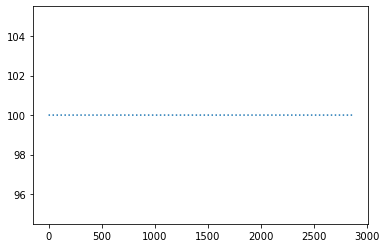

In [16]:
VizualizeData(NetWorthAfterEachTrade) 

You may need to declare the PartitionedData list global, depending on your implementation of the Above snippet as well as the various functions in the Portfolio class.

##Moment of Truth

Time to check, if your Program actually works!

Plot the data you collected in various ways (Profits, PercentageProfits etc.) and see if what you did worked!

Feel free to use whichever one of Matplotlib or Seaborn you want to.

Feel free to copy-paste your code from the previous assignment!

You may use this cell to write about your results/performance of the model!

ChangePairs and RebalancePortfolio are remaining